<a href="https://colab.research.google.com/github/theunknowncoder69/A-Robust-Biometric-Template-Protection-Scheme-Using-Fuzzy-Vault-Cryptography/blob/main/NIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s "Youtube Comments Dataset"

ref                                                                title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
atifaliak/youtube-comments-dataset                                 Youtube Comments Dataset                               1261853  2025-01-28 08:43:46.340000           8168         81  1.0              
ahsenwaheed/youtube-comments-spam-dataset                          Youtube Comments Spam Dataset                           162831  2024-08-12 16:31:41.603000           3112         47  1.0              
datasnaek/youtube-new                                              Trending YouTube Video Statistics                    210575746  2019-06-03 00:56:47.177000         281880       5760  0.7

In [ ]:
!kaggle datasets download -d atifaliak/youtube-comments-dataset
!unzip '*.zip'

Dataset URL: https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset
License(s): DbCL-1.0
youtube-comments-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  youtube-comments-dataset.zip
replace YoutubeCommentsDataSet.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: YoutubeCommentsDataSet.csv  


In [ ]:
import pandas as pd

df = pd.read_csv('YoutubeCommentsDataSet.csv')
print(df.head())
print(df.columns)

                                                                                                                                                                                                                                                                                                                                                                                                                                                              Comment Sentiment
0                                                                                                                                       lets not forget that apple pay in 2014 required a brand new iphone in order to use it a significant portion of apples user base wasnt able to use it even if they wanted to as each successive iphone incorporated the technology and older iphones were replaced the number of people who could use the technology increased   neutral
1                                                                       

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [ ]:
print(df.value_counts('Sentiment'))

Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64


In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['Comment'], inplace=True)

In [ ]:
df['Comment'] = df['Comment'].str.lower()

In [ ]:
import re

def clean_text(Comment):
    Comment = re.sub(r'http\S+', '', Comment)  # remove URLs
    Comment = re.sub(r'@\w+', '', Comment)     # remove mentions
    Comment = re.sub(r'#\w+', '', Comment)     # remove hashtags
    Comment = re.sub(r'[^a-zA-Z\s]', '', Comment)  # remove non-alphabet chars
    Comment = re.sub(r'\s+', ' ', Comment).strip() # remove extra spaces
    return Comment

df['clean_text'] = df['Comment'].apply(clean_text)

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=18500)  # Or adjust as needed
X = tfidf.fit_transform(df['clean_text'])
y = df['Sentiment']

ML models

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=30, n_jobs=-1),
    'Support Vector Machine': LinearSVC(max_iter=500),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=30)
}

# Binarize labels for ROC-AUC
classes = df['Sentiment'].unique()
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# Initialize results list
results = []

# Use StratifiedKFold to preserve class ratios
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Running 10-fold CV for {name}...")

    acc_list, prec_list, rec_list, f1_list = [], [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        y_test_bin = y_bin[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_bin = label_binarize(y_pred, classes=classes)

        # Metrics
        acc_list.append(accuracy_score(y_test, y_pred))
        prec_list.append(precision_score(y_test, y_pred, average=None, labels=classes))
        rec_list.append(recall_score(y_test, y_pred, average=None, labels=classes))
        f1_list.append(f1_score(y_test, y_pred, average=None, labels=classes))

    # Average per class across folds
    avg_prec = np.mean(prec_list, axis=0)
    avg_rec = np.mean(rec_list, axis=0)
    avg_f1 = np.mean(f1_list, axis=0)

    results.append({
        'Model': name,
        'Accuracy (mean)': np.mean(acc_list),
        'Precision per class': dict(zip(classes, avg_prec)),
        'Recall per class': dict(zip(classes, avg_rec)),
        'F1-score per class': dict(zip(classes, avg_f1)),
    })

results_df = pd.DataFrame(results)
for i, row in results_df.iterrows():
    # Accuracy in percentage
    results_df.at[i, 'Accuracy (mean)'] = round(row['Accuracy (mean)'] * 100, 2)

    # Round per-class metrics
    for metric in ['Precision per class', 'Recall per class', 'F1-score per class']:
        results_df.at[i, metric] = {k: round(v, 2) for k, v in row[metric].items()}

pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 700)         # set display width
print(results_df)



Running 10-fold CV for Logistic Regression...
Running 10-fold CV for Random Forest...
Running 10-fold CV for Support Vector Machine...
Running 10-fold CV for Multinomial Naive Bayes...
Running 10-fold CV for Gradient Boosting...
                     Model  Accuracy (mean)                                    Precision per class                                       Recall per class                                     F1-score per class
0      Logistic Regression            74.94  {'neutral': 0.61, 'negative': 0.68, 'positive': 0.81}   {'neutral': 0.59, 'negative': 0.3, 'positive': 0.91}   {'neutral': 0.6, 'negative': 0.42, 'positive': 0.85}
1            Random Forest            72.47  {'neutral': 0.62, 'negative': 0.69, 'positive': 0.76}  {'neutral': 0.56, 'negative': 0.16, 'positive': 0.91}  {'neutral': 0.59, 'negative': 0.26, 'positive': 0.83}
2   Support Vector Machine            74.77   {'neutral': 0.58, 'negative': 0.6, 'positive': 0.83}   {'neutral': 0.6, 'negative': 0.43, 'positiv

Generating ROC curves for class 'Negative'...


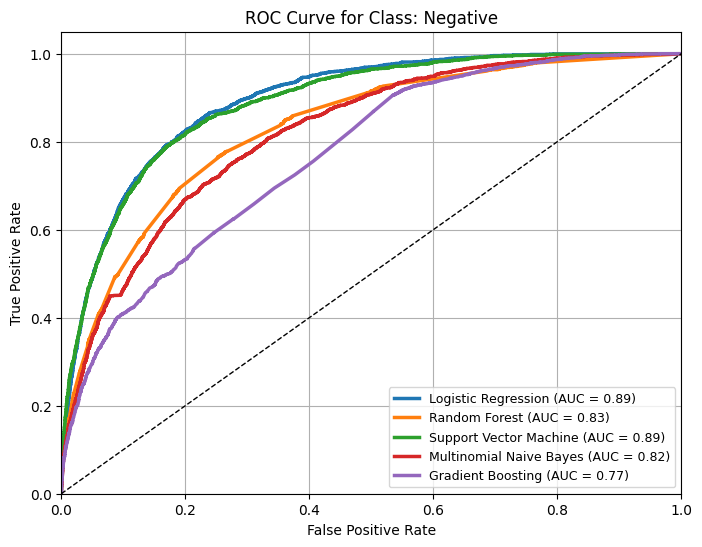

Generating ROC curves for class 'Neutral'...


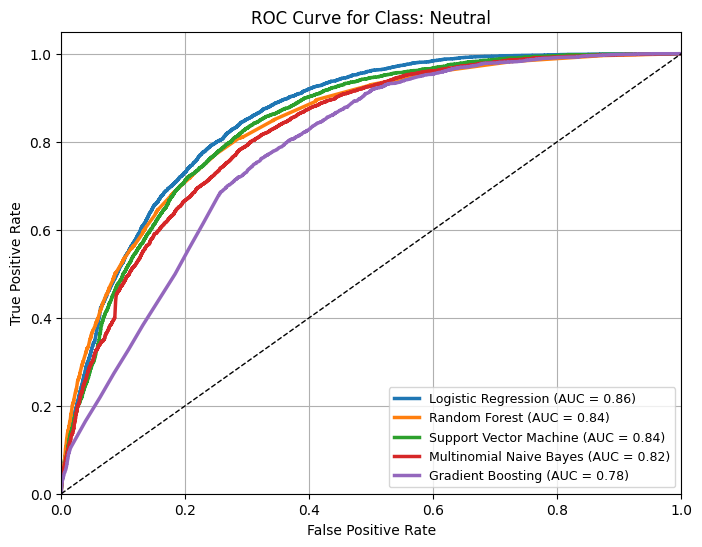

Generating ROC curves for class 'Positive'...


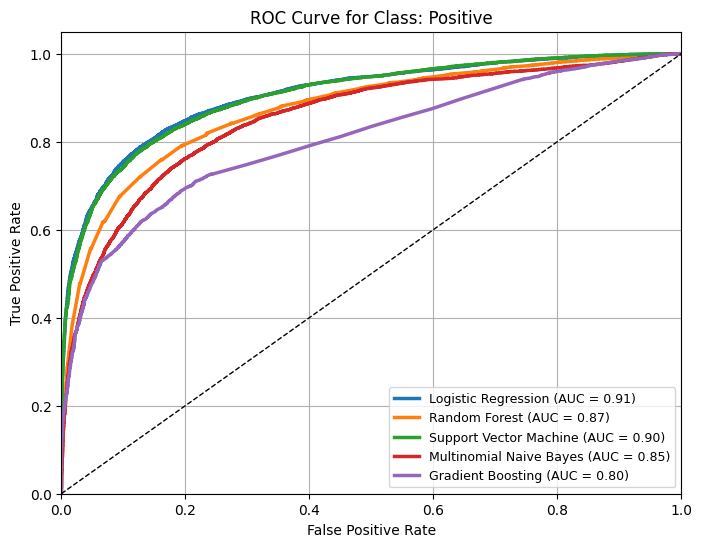

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import label_binarize

# Class labels
classes = ["Negative", "Neutral", "Positive"]

# Binarize y for multiclass ROC
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Define CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop through each class
for i, cls in enumerate(classes):
    plt.figure(figsize=(8, 6))
    print(f"Generating ROC curves for class '{cls}'...")

    for name, model in models.items():
        # Calibrate SVM for probability prediction
        if name == "Support Vector Machine":
            model = CalibratedClassifierCV(model)

        # Cross-validated predicted probabilities
        y_score = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)

        # ROC
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc_val = auc(fpr, tpr)

        plt.plot(fpr, tpr, linewidth=2.5, label=f"{name} (AUC = {roc_auc_val:.2f})")  # thicker line

    # Plot settings
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for Class: {cls}")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True)
    plt.show()





TF-IDF

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Class names
classes = le.classes_

# Setup cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track metrics
cv_accuracies = []
cv_precisions = []
cv_recalls = []
cv_f1s = []

# Convert features to array
X_array = X.toarray()

for fold, (train_idx, val_idx) in enumerate(kf.split(X_array, y_enc), 1):
    print(f"🔁 Fold {fold}")

    # Split the data
    X_train, X_val = X_array[train_idx], X_array[val_idx]
    y_train, y_val = y_enc[train_idx], y_enc[val_idx]

    # Build model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.8),
        Dense(64, activation='relu'),
        Dropout(0.8),
        Dense(len(classes), activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    # Train
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=128,
        verbose=0
    )

    # Predict classes
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Evaluate
    accuracy = np.mean(y_pred == y_val)
    cv_accuracies.append(accuracy)

    # Compute per-class metrics
    precision = precision_score(y_val, y_pred, average=None, labels=np.arange(len(classes)))
    recall = recall_score(y_val, y_pred, average=None, labels=np.arange(len(classes)))
    f1 = f1_score(y_val, y_pred, average=None, labels=np.arange(len(classes)))

    cv_precisions.append(precision)
    cv_recalls.append(recall)
    cv_f1s.append(f1)

    print(f"✅ Fold {fold} Accuracy: {accuracy:.2f}")
    print(f"   Precision: {precision}")
    print(f"   Recall:    {recall}")
    print(f"   F1-score:  {f1}\n")

# Average metrics across folds
mean_acc = np.mean(cv_accuracies)
mean_prec = np.mean(cv_precisions, axis=0)
mean_rec = np.mean(cv_recalls, axis=0)
mean_f1 = np.mean(cv_f1s, axis=0)

print("🎯 Average CV Metrics per Class:")
for i, cls in enumerate(classes):
    print(f"Class '{cls}': Precision={mean_prec[i]:.2f}, Recall={mean_rec[i]:.2f}, F1={mean_f1[i]:.2f}")
print(f"\nOverall Average Accuracy: {mean_acc:.2f}")


🔁 Fold 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Fold 1 Accuracy: 0.76
   Precision: [0.62745098 0.60714286 0.84383089]
   Recall:    [0.41558442 0.64079823 0.88426763]
   F1-score:  [0.5        0.62351672 0.86357616]

🔁 Fold 2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✅ Fold 2 Accuracy: 0.74
   Precision: [0.59064327 0.5631068  0.85208711]
   Recall:    [0.43722944 0.64301552 0.84900542]
   F1-score:  [0.50248756 0.60041408 0.85054348]

🔁 Fold 3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ Fold 3 Accuracy: 0.76
   Precision: [0.57954545 0.62242563 0.83829787]
   Recall:    [0.44155844 0.60310421 0.89059675]
   F1-score:  [0.5012285  0.61261261 0.86365629]

🔁 Fold 4


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Fold 4 Accuracy: 0.75
   Precision: [0.60555556 0.58924731 0.83727034]
   Recall:    [0.46982759 0.60888889 0.86528029]
   F1-score:  [0.52912621 0.5989071  0.85104491]

🔁 Fold 5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Fold 5 Accuracy: 0.76
   Precision: [0.64150943 0.5974026  0.84048027]
   Recall:    [0.43965517 0.61333333 0.88687783]
   F1-score:  [0.52173913 0.60526316 0.86305592]

🔁 Fold 6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✅ Fold 6 Accuracy: 0.74
   Precision: [0.57803468 0.56389452 0.84210526]
   Recall:    [0.43103448 0.61777778 0.85429864]
   F1-score:  [0.49382716 0.58960764 0.84815813]

🔁 Fold 7


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✅ Fold 7 Accuracy: 0.75
   Precision: [0.66887417 0.54972875 0.85872576]
   Recall:    [0.43534483 0.67555556 0.84162896]
   F1-score:  [0.52741514 0.60618146 0.85009141]

🔁 Fold 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Fold 8 Accuracy: 0.76
   Precision: [0.60119048 0.58502024 0.85422222]
   Recall:    [0.43534483 0.64222222 0.86968326]
   F1-score:  [0.505      0.61228814 0.86188341]

🔁 Fold 9


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Fold 9 Accuracy: 0.73
   Precision: [0.65217391 0.53293413 0.82664389]
   Recall:    [0.32327586 0.59333333 0.8760181 ]
   F1-score:  [0.43227666 0.5615142  0.85061511]

🔁 Fold 10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✅ Fold 10 Accuracy: 0.75
   Precision: [0.61797753 0.58004158 0.84042553]
   Recall:    [0.47413793 0.62       0.85791855]
   F1-score:  [0.53658537 0.59935553 0.84908195]

🎯 Average CV Metrics per Class:
Class 'negative': Precision=0.62, Recall=0.43, F1=0.50
Class 'neutral': Precision=0.58, Recall=0.63, F1=0.60
Class 'positive': Precision=0.84, Recall=0.87, F1=0.86

Overall Average Accuracy: 0.75


USE

In [ ]:
!pip install tensorflow_hub

import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Load USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_embed = embed(df['Comment'].fillna('').astype(str).tolist()).numpy()

# 🎯 Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(df['Sentiment'])
classes = le.classes_

# ✅ 10-Fold Stratified CV
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track metrics
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_embed, y_enc), 1):
    print(f"\n📂 Fold {fold}/10")

    X_train, X_val = X_embed[train_idx], X_embed[val_idx]
    y_train, y_val = y_enc[train_idx], y_enc[val_idx]

    # Build model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(512,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    # Train
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=0
    )

    # Predict
    y_pred = np.argmax(model.predict(X_val), axis=1)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)

    precision = precision_score(y_val, y_pred, average=None, labels=np.arange(len(classes)))
    recall = recall_score(y_val, y_pred, average=None, labels=np.arange(len(classes)))
    f1 = f1_score(y_val, y_pred, average=None, labels=np.arange(len(classes)))

    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

    print(f"✅ Fold {fold} Accuracy: {acc:.2f}")
    print(f"   Precision: {np.round(precision,2)}")
    print(f"   Recall:    {np.round(recall,2)}")
    print(f"   F1-score:  {np.round(f1,2)}")

# 📊 Average metrics across folds
mean_acc = np.mean(fold_accuracies)
mean_prec = np.mean(fold_precisions, axis=0)
mean_rec = np.mean(fold_recalls, axis=0)
mean_f1 = np.mean(fold_f1s, axis=0)

print("\n🎯 Average 10-Fold Metrics per Class:")
for i, cls in enumerate(classes):
    print(f"Class '{cls}': Precision={mean_prec[i]:.2f}, Recall={mean_rec[i]:.2f}, F1={mean_f1[i]:.2f}")
print(f"\nOverall Average Accuracy: {mean_acc:.2f}")




📂 Fold 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Fold 1 Accuracy: 0.81
   Precision: [0.7  0.69 0.88]
   Recall:    [0.64 0.69 0.89]
   F1-score:  [0.67 0.69 0.88]

📂 Fold 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Fold 2 Accuracy: 0.77
   Precision: [0.58 0.64 0.86]
   Recall:    [0.5  0.65 0.88]
   F1-score:  [0.54 0.65 0.87]

📂 Fold 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Fold 3 Accuracy: 0.80
   Precision: [0.64 0.69 0.87]
   Recall:    [0.64 0.63 0.9 ]
   F1-score:  [0.64 0.66 0.88]

📂 Fold 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Fold 4 Accuracy: 0.79
   Precision: [0.6  0.67 0.88]
   Recall:    [0.58 0.69 0.88]
   F1-score:  [0.59 0.68 0.88]

📂 Fold 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Fold 5 Accuracy: 0.80
   Precision: [0.65 0.7  0.88]
   Recall:    [0.59 0.66 0.91]
   F1-score:  [0.62 0.68 0.89]

📂 Fold 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✅ Fold 6 Accuracy: 0.80
   Precision: [0.67 0.69 0.87]
   Recall:    [0.64 0.66 0.89]
   F1-score:  [0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import tensorflow as tf
from sentence_transformers import SentenceTransformer

# 📌 Load data
df = pd.read_csv("YoutubeCommentsDataSet.csv")
comments = df['Comment'].fillna('').astype(str).tolist()
labels = df['Sentiment']

# 📌 Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
class_names = le.classes_   # e.g. ['negative','neutral','positive']

# 📌 Models (only BERT + DistilBERT)
models = {

    "BERT": SentenceTransformer('all-MiniLM-L6-v2'),
    "DistilBERT": SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for model_name, embedder in models.items():
    print(f"\n🔍 Processing {model_name}")
    # Feature extraction
    X = embedder.encode(comments, show_progress_bar=True, convert_to_numpy=True)

    all_y_true, all_y_pred, all_y_probs = [], [], []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Simple neural classifier
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X.shape[1],)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation='softmax')
        ])
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=['accuracy']
        )

        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=10, batch_size=32, verbose=0)

        y_prob = model.predict(X_val)
        y_pred = np.argmax(y_prob, axis=1)

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_probs.extend(y_prob)

    # Convert to arrays
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)

    # 📌 Compute overall metrics
    acc  = accuracy_score(all_y_true, all_y_pred)
    prec_macro = precision_score(all_y_true, all_y_pred, average="macro")
    rec_macro  = recall_score(all_y_true, all_y_pred, average="macro")
    f1_macro   = f1_score(all_y_true, all_y_pred, average="macro")

    # 📌 Per-class metrics
    class_report = classification_report(
        all_y_true, all_y_pred,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    per_class_metrics = {
        cls: {
            "Precision": round(class_report[cls]["precision"], 2),
            "Recall": round(class_report[cls]["recall"], 2),
            "F1": round(class_report[cls]["f1-score"], 2)
        }
        for cls in class_names
    }

    results.append({
        "Model": model_name,
        "Accuracy": round(acc, 2),
        "Precision (macro)": round(prec_macro, 2),
        "Recall (macro)": round(rec_macro, 2),
        "F1-score (macro)": round(f1_macro, 2),
        "Per-class": per_class_metrics
    })

# 📌 Show results
results_df = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
print("\n✅ Model Evaluation Results (10-Fold CV):")
print(results_df)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


🔍 Processing BERT


Batches:   0%|          | 0/576 [00:00<?, ?it/s]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🔍 Processing DistilBERT


Batches:   0%|          | 0/576 [00:00<?, ?it/s]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Model Evaluation Results (10-Fold CV):
        Model  Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)                                                                                                                                                                               Per-class
0        BERT      0.79               0.72            0.70              0.71  {'negative': {'Precision': 0.64, 'Recall': 0.58, 'F1': 0.61}, 'neutral': {'Precision': 0.66, 'Recall': 0.63, 'F1': 0.64}, 'positive': {'Precision': 0.86, 'Recall': 0.89, 'F1': 0.87}}
1  DistilBERT      0.81               0.76            0.73              0.74   {'negative': {'Precision': 0.72, 'Recall': 0.63, 'F1': 0.67}, 'neutral': {'Precision': 0.67, 'Recall': 0.68, 'F1': 0.67}, 'positive': {'Precision': 0.88


🔍 Processing TF-IDF

🔍 Processing USE

🔍 Processing BERT


Batches:   0%|          | 0/576 [00:00<?, ?it/s]


🔍 Processing DistilBERT


Batches:   0%|          | 0/576 [00:00<?, ?it/s]

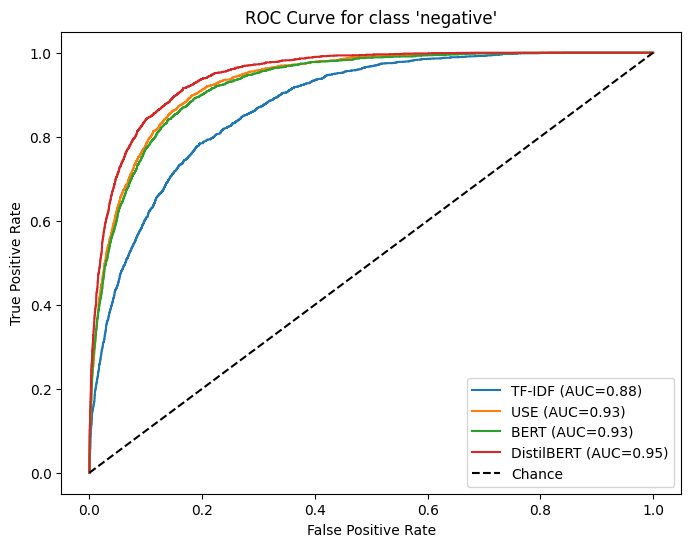

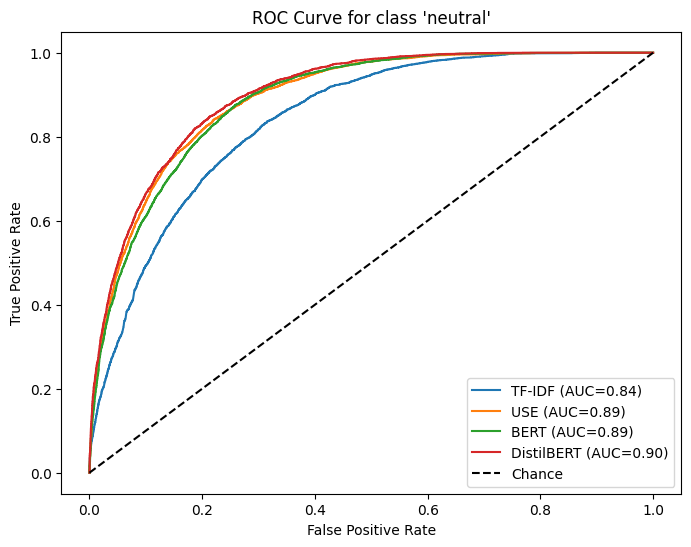

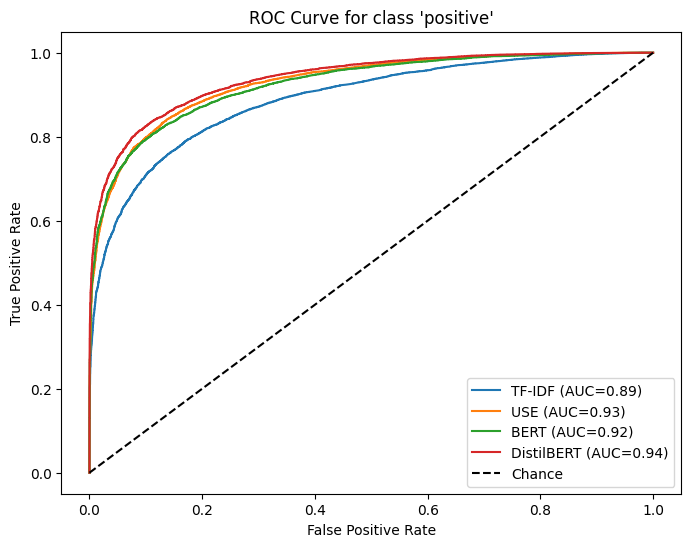

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
import tensorflow as tf

# 🔹 Collect results from all models
all_y_true_dict = {}
all_y_probs_dict = {}

# 🔹 Define models
models1 = {
    "TF-IDF": "tfidf",  # handled separately
    "USE": hub.load("https://tfhub.dev/google/universal-sentence-encoder/4"),
    "BERT": SentenceTransformer('all-MiniLM-L6-v2'),
    "DistilBERT": SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
}

for model_name, embedder in models1.items():
    print(f"\n🔍 Processing {model_name}")

    # Step 1: Prepare embeddings
    if model_name == "TF-IDF":
        vectorizer = TfidfVectorizer(max_features=5000)
        X = vectorizer.fit_transform(comments).toarray()

    elif model_name == "USE":
        X = embedder(comments).numpy()

    else:  # BERT or DistilBERT
        X = embedder.encode(comments, show_progress_bar=True, convert_to_numpy=True)

    # Step 2: Train classifier with cross-validation
    all_y_true, all_y_probs = [], []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X.shape[1],)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation='softmax')
        ])
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=['accuracy']
        )

        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=10, batch_size=32, verbose=0)

        y_prob = model.predict(X_val, verbose=0)

        all_y_true.extend(y_val)
        all_y_probs.extend(y_prob)

    # Step 3: Store results
    all_y_true_dict[model_name] = np.array(all_y_true)
    all_y_probs_dict[model_name] = np.array(all_y_probs)

# 🔹 ROC Curves per class
y_true_bin = label_binarize(y, classes=list(range(len(class_names))))

for i, cls in enumerate(class_names):
    plt.figure(figsize=(8,6))
    for model_name in all_y_true_dict.keys():
        y_true_model = label_binarize(all_y_true_dict[model_name], classes=list(range(len(class_names))))
        y_probs_model = all_y_probs_dict[model_name]

        fpr, tpr, _ = roc_curve(y_true_model[:, i], y_probs_model[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")

    plt.plot([0,1],[0,1],'k--',label="Chance")
    plt.title(f"ROC Curve for class '{cls}'")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


BERT

In [ ]:
'''!pip install -q sentence-transformers'''

In [ ]:
'''import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sentence_transformers import SentenceTransformer'''

In [ ]:
'''comments = df['Comment'].fillna('').astype(str).tolist()
labels = df['Sentiment']'''

In [ ]:
'''le = LabelEncoder()
y = le.fit_transform(labels)'''

In [ ]:
'''model_bert = SentenceTransformer('all-MiniLM-L6-v2')  # Compact and fast
X_embed = model_bert.encode(comments, show_progress_bar=True)'''

In [ ]:
'''kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_embed, y), 1):
    print(f"\n📂 Fold {fold}/10")

    X_train, X_val = X_embed[train_idx], X_embed[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_embed.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(le.classes_), activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=0
    )

    y_pred = np.argmax(model.predict(X_val), axis=1)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"✅ Fold {fold} accuracy: {acc:.4f}")'''

In [ ]:
'''print(np.mean(fold_accuracies))'''

DistilBert

In [ ]:
'''distilbert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
X_embed = distilbert_model.encode(comments, show_progress_bar=True)'''

In [ ]:
'''kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_embed, y), 1):
    print(f"\n📂 Fold {fold}/10")

    X_train, X_val = X_embed[train_idx], X_embed[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_embed.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(le.classes_), activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=0
    )

    y_pred = np.argmax(model.predict(X_val), axis=1)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"✅ Fold {fold} accuracy: {acc:.4f}")'''

In [ ]:
'''print(np.mean(fold_accuracies))'''

In [ ]:
'''import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import product
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# 📌 Load and encode data
comments = df['Comment'].fillna('').astype(str).tolist()
labels = df['Sentiment']
le = LabelEncoder()
y = le.fit_transform(labels)
class_names = le.classes_  # ['negative', 'neutral', 'positive']

# 📌 Models
models = {
    "TF-IDF": TfidfVectorizer(max_features=5000),
    "USE": hub.load("https://tfhub.dev/google/universal-sentence-encoder/4"),
    "BERT": SentenceTransformer('all-MiniLM-L6-v2'),
    "DistilBERT": SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
}

# 📌 Stratified CV
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 📌 Storage for ROC data
roc_data = []

for model_name, embedder in models.items():
    print(f"\n🔍 Processing {model_name}")

    # Feature extraction
    if model_name == "TF-IDF":
        X = embedder.fit_transform(comments).toarray()
    elif model_name == "USE":
        X = embedder(comments).numpy()
    else:
        X = embedder.encode(comments, show_progress_bar=True)

    all_y_true, all_y_probs = [], []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X.shape[1],)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation='softmax')
        ])
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=['accuracy']
        )

        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=10, batch_size=32, verbose=0)

        y_prob = model.predict(X_val)
        all_y_true.extend(y_val)
        all_y_probs.extend(y_prob)

    # Binarize and convert to arrays
    y_true_bin = label_binarize(all_y_true, classes=[0, 1, 2])
    y_prob = np.array(all_y_probs)

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_score = auc(fpr, tpr)
        roc_data.append((fpr, tpr, f"{model_name} - {class_names[i]}", auc_score))'''

'import numpy as np\nimport pandas as pd\nfrom sklearn.preprocessing import LabelEncoder, label_binarize\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.metrics import roc_curve, auc\nimport matplotlib.pyplot as plt\nfrom itertools import product\nimport tensorflow as tf\nimport tensorflow_hub as hub\nfrom sentence_transformers import SentenceTransformer\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\n# 📌 Load and encode data\ncomments = df[\'Comment\'].fillna(\'\').astype(str).tolist()\nlabels = df[\'Sentiment\']\nle = LabelEncoder()\ny = le.fit_transform(labels)\nclass_names = le.classes_  # [\'negative\', \'neutral\', \'positive\']\n\n# 📌 Models\nmodels = {\n    "TF-IDF": TfidfVectorizer(max_features=5000),\n    "USE": hub.load("https://tfhub.dev/google/universal-sentence-encoder/4"),\n    "BERT": SentenceTransformer(\'all-MiniLM-L6-v2\'),\n    "DistilBERT": SentenceTransformer(\'distilbert-base-nli-stsb-mean-tokens\')\n}\n\n# 📌 Stratified CV\nkf =

In [ ]:
'''# 🎨 Combined ROC Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab20', len(roc_data))  # distinct colors

for idx, (fpr, tpr, label, auc_score) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})", color=colors(idx))

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title("📊 Combined ROC Curve for All Models & Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()'''

'plt.figure(figsize=(12, 8))\ncolors = plt.cm.get_cmap(\'tab20\', len(roc_data))  # distinct colors\n\nfor idx, (fpr, tpr, label, auc_score) in enumerate(roc_data):\n    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})", color=colors(idx))\n\nplt.plot([0, 1], [0, 1], \'k--\', label=\'Random Chance\')\nplt.title("📊 Combined ROC Curve for All Models & Classes")\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\nplt.legend(loc="lower right", fontsize=\'small\')\nplt.grid(True)\nplt.tight_layout()\nplt.show()'